# Проект "Отток посетителей фитнес-центра"

##  Синопсис проекта

Для снижения оттока посетителей фитнес-клуба необходимо проанализировать имеющиеся сведения о посетителях и дать ряд рекомендаций для формирования маркетинговых мероприятий, которые будут направленны на снижение показателя оттока.

## Задачи проекта

Провести анализ и подготовить план действий по удержанию клиентов.
В том числе:
- Построить модели, предстказывающие вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
     - выделить целевые группы клиентов;
     - предложить меры по снижению оттока;
     - определить другие особенности взаимодействия с клиентами.

## Блок для загружаемых библиотек, необходимых для проекта

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso, Ridge
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)

## Описание датасета

Нам предоставлено следующее обписание к датасету.

Набор данных включает следующие поля:


Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

### Просмотр датасета

In [28]:
#Посмотрим на имеющиеся у нас данные
gym_data = pd.read_csv('/datasets/gym_churn.csv')

In [29]:
#Напишем функцию, которая предоставит необходимые общие сведения, в том числе о наличии очевидных дубликатов
def view(data):
    return (
           display(data.head(5)),
           display(data.info()),
           print(f'В датасете {len(data) - len(data.drop_duplicates())} дубликатов')           
    )
view(gym_data)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

В датасете 0 дубликатов


(None, None, None)

**Вывод** 
- В датасете можно отметить, что названия столбцов можно привести к единому регистру
- В датасете отсутствуют явные дубликаты
- Столбец `Month_to_end_contract` можно привести к типу данных `int`

### Предобработка датасета

In [30]:
gym_data.columns = gym_data.columns.str.lower()

In [31]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [32]:
gym_data['month_to_end_contract'] = gym_data['month_to_end_contract'].astype('int') 

### Составим портрет среднестатистического посетителя

In [33]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


**Промежуточные выводы**:
- В имеющемся датасете примерно равное количество мужчин и женщин
- Примерно 85% живут или работают рядом с фитнес-центром
- 49% посетителей являются работниками корпоративных клиентов фитнес-центра
- 31% клиентов пришли по акции "Приведи друга"
- по 90% клиентов есть контактные данные
- Средний контрактный период посетителей составляет немного более 4 с половиной месяцев
- 41% посетителей посещали групповые занятия
- Средний возраст по выборке - 29 лет
- Средняя выручка, которую один клиент тратил на дополнительные услуги составляет 147 рублей
- Средний остаток по абонементу составляет 4 месяца и 10 дней
- Среднее время с первого посещения фитнес центра составляет немного меньше 4 месяцев
- Среднее количество посещений в неделю как за весь период, так и за последний месяц составляет немного меньше 2 раз
- Процент оттока составляет 27%

### Составим портрет среднестатистических посетителей по группам ушедших и оставшихся

In [34]:
# посмотрим среднее по группам ушедших и оставшихся
gym_data.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


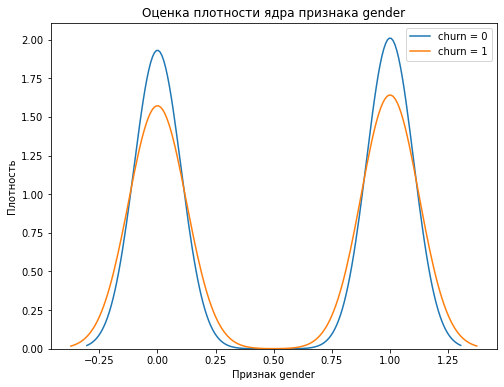

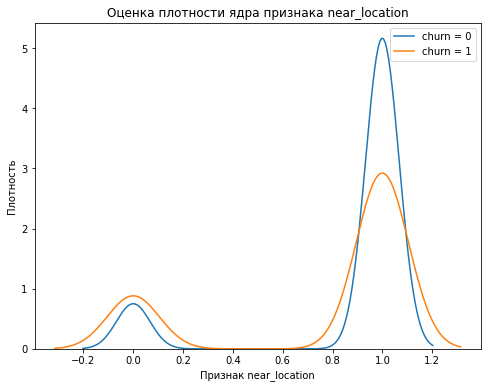

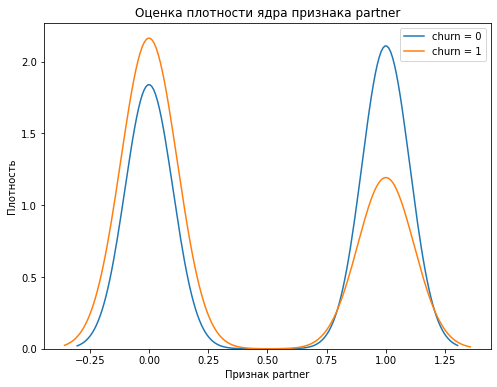

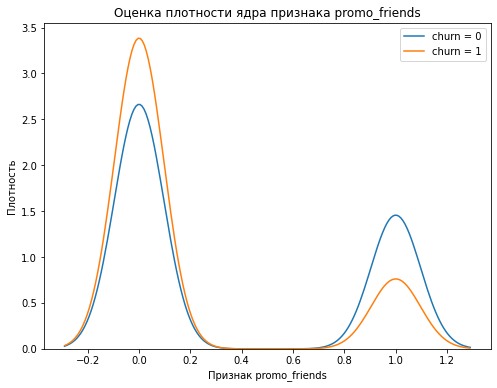

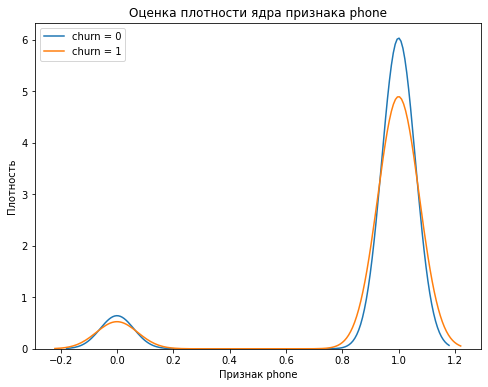

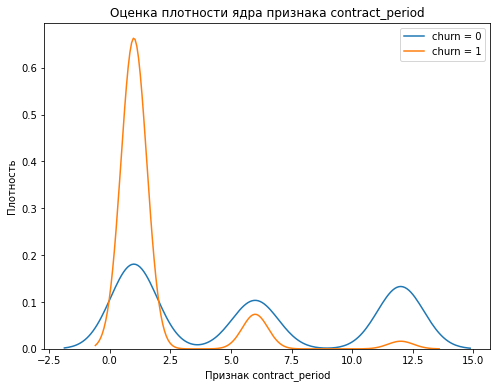

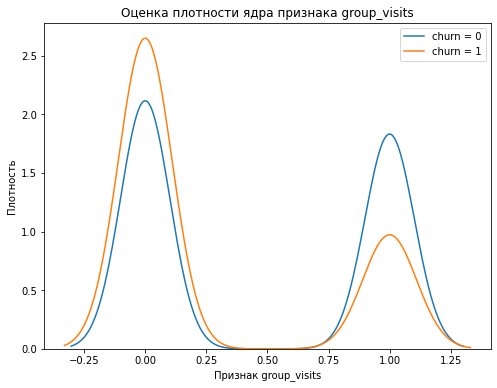

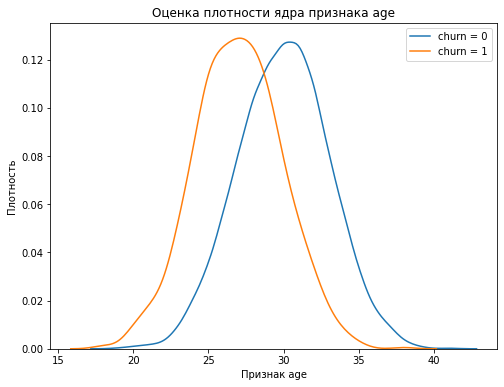

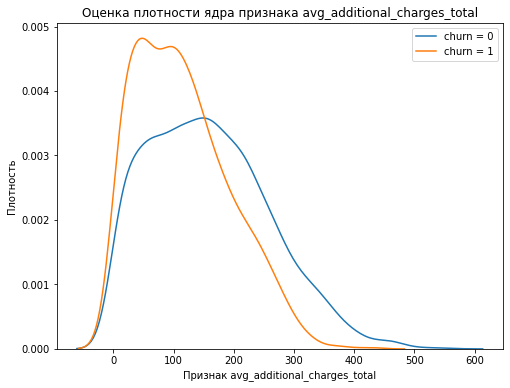

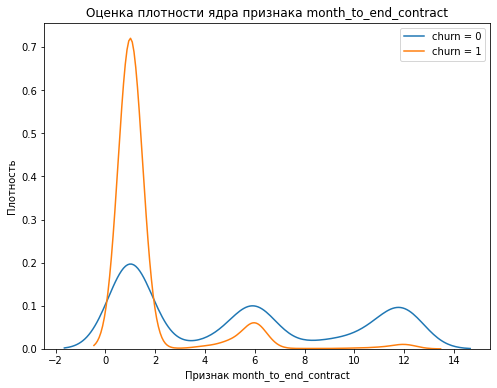

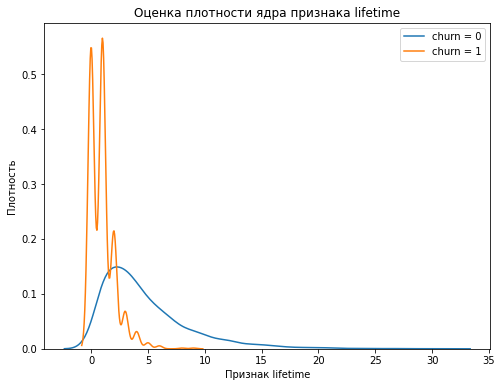

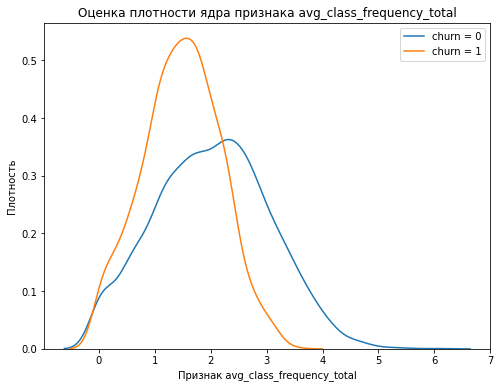

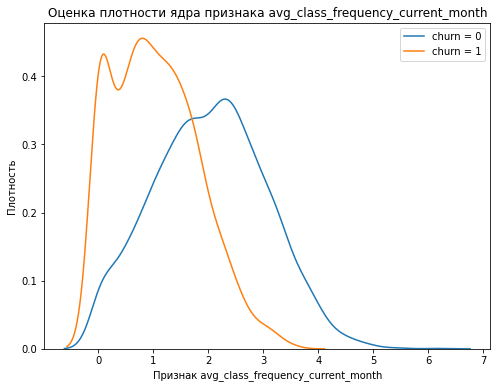

In [35]:
# Визуализируем распределение по признакам между двумя группами
for column in gym_data.drop('churn', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.kdeplot(gym_data.query('churn == 0')[column])
    sns.kdeplot(gym_data.query('churn == 1')[column])
    plt.title(f"Оценка плотности ядра признака {column}")
    plt.xlabel(f'Признак {column}') 
    plt.ylabel('Плотность') 
    ax.legend(['churn = 0', 'churn = 1'])
    plt.show

**Промежуточные выводы**:
- В группах приблизительное равно распределение по признаку пола, то есть уходят и остаются в равной степени и мужчины и женщины
- В группе ушедших посетителй процент тех, кто не живет рядом с фитнес-центром немного, но не значительно меньше относительно группы оставшихся
- В группе ушедших немного больше трети работников корпоративных клиентов, в то время как в группе оставшихся этот показатель составляет немного более 50%
- Только 18% ушедших клиентов пришли по акции "Приведи друга", в то время как процент таких оставшихся клиентов составляет 35%
- по 90% как ушедших, так и оставшихся клиентов есть контактные данные
- Средний контрактный период ушедших посетителей составляет немного более полутора месяцев, в то время как у группы оставшихся этот показатель составляет немного меньше 6 месяцев
- только 27% ушедших посетителей посещали групповые занятия, в то время как у оставшихся это 46%
- Средний возраст ушедших - 27 лет, оставшихся - 30 лет
- Средняя выручка, которую один ушедший клиент тратил на дополнительные услуги составляет примерно на треть меньше, чем оставшиеся клиенты
- Средний остаток по абонементу ушедших клиентов составляет примерно 1 месяц и 3 недели, оставшегося - немного больше 5 месяцев
- Среднее время с первого посещения фитнес центра ушедшего клиента составляет немного меньше 1 месяца, оставшиеся ходят в среднем более 4 с половиной месяцев
- В среднем ушедшие посещали фитнес центр от 1 до полутора раз  неделю, а оставшиеся не менее 2.

**Портрет ушедшего клиента**
- Ориентировочно 27 лет
- Может быть как мужчиной, так и женщиной
- Вероятно не является работником корпоративного клиента и не пришел по акции "Приведи друга"
- Ходит в фитнес-клуб 1 месяца, при этом предпочитает покупать следующий абонемент также на месяц
- Занимается в среднем 1 раз в неделю
- Вероятно не ходит на групповые занятия и не очень охотно тратит деньги на дополнительные услуги предоставляемые фитнес-центром

### Визуализируем матрицу корреляции признаков

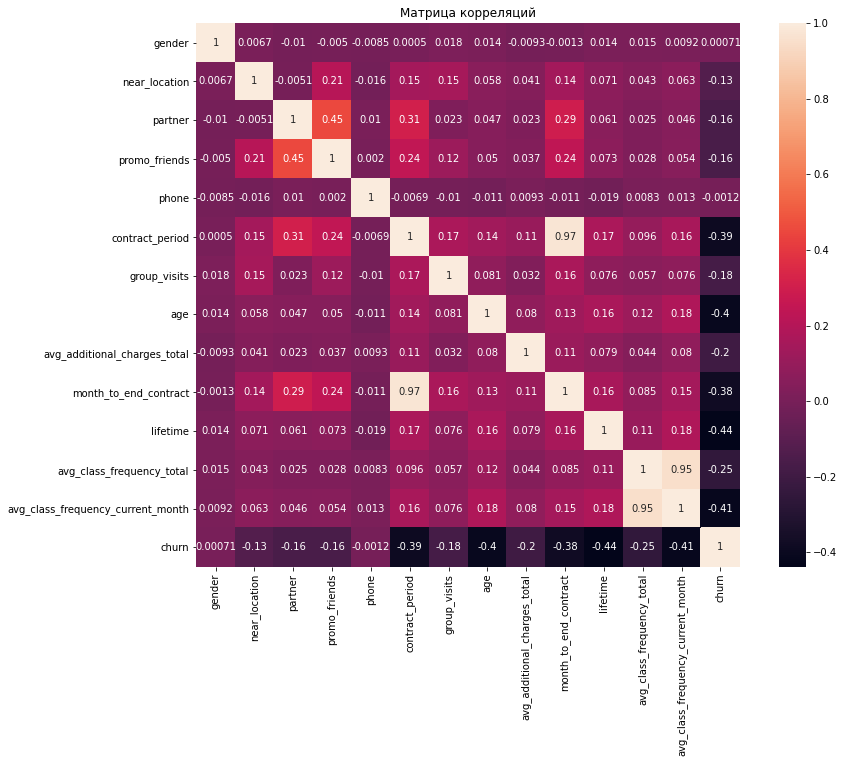

In [36]:
corr_m = gym_data.corr()
plt.figure(figsize=(14,10)) 
sns.heatmap(corr_m, square = True, annot = True)
plt.title('Матрица корреляций') 
plt.show()


**Выводы** В соответствии с матрицей корреляции мы выявили 2 пары взаимно коррелирующих признаков: 
- период действия абонемента/период до окончания действующего абонемента (`contract_period`/`month_to_end_contract`)
- среднее количество посещений в неделю за весь период/среднее количество посещений в неделю за последний месяц(`avg_class_frequency_total`/`avg_class_frequency_current_month`)
- также вызывает вопросы признак `phone` корреляция которого с остальными признаками вызывает больше всего вопросов.

## Модель прогнозирования оттока клиентов

Для целей обучения моделей, необходимо регуляризировать имеющиеся данные, в связи с чем необходимо удалить по одному коррелирующему признаку из имеющихся пар, а также признак `phone`. Удаление `month_to_end_contract` продиктовано тем, что на мой взгляд период остающийся до конца абонемента менее характеризует посетителя, чем период на который абонемент был приобретен. `avg_class_frequency_total` был выбран для удаления, поскольку для целей проект предпочтительнее показатель посещаемости за ближайший период к периоду исследования.

<function matplotlib.pyplot.show(close=None, block=None)>

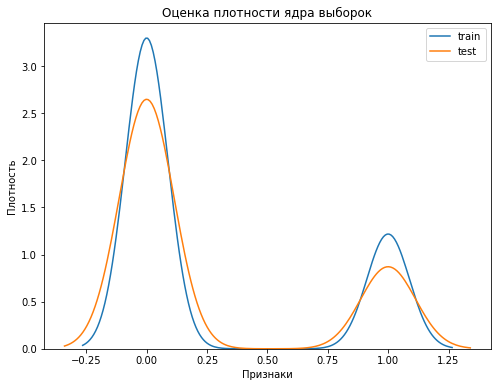

In [37]:
gym_data_ml = gym_data.drop(['month_to_end_contract', 'avg_class_frequency_total', 'phone'], axis = 1)

X = gym_data_ml.drop('churn', axis = 1)
y = gym_data_ml['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# визуализируем выборки
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(y_train) 
sns.kdeplot(y_test) 
plt.title(f"Оценка плотности ядра выборок")
plt.xlabel(f'Признаки') 
plt.ylabel('Плотность') 
ax.legend(['train', 'test'])
plt.show

**Промежуточный вывод** Выборки выглядят равномерыми

In [38]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [48]:
# напишем функцию вывода метрик
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

    
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.77
	F1: 0.79


**Выводы** В целом модели показали сопоставимые результаты. Модель логистической регрессии чуть менее точно предсказала какое количество клиентов уйдет среди всех фактически ушедших, в то же время она предсказала большее количество реально ушедших клиентов среди всех клиентов. Метрика F1 говорит, что по балансу этих метрик немного выигрывает Модель логистической регрессиию.

## Кластеризация клиентов


### Построение дендрограммы

In [40]:
gym_data_sc = scaler.fit_transform(gym_data.drop(columns = ['churn']))

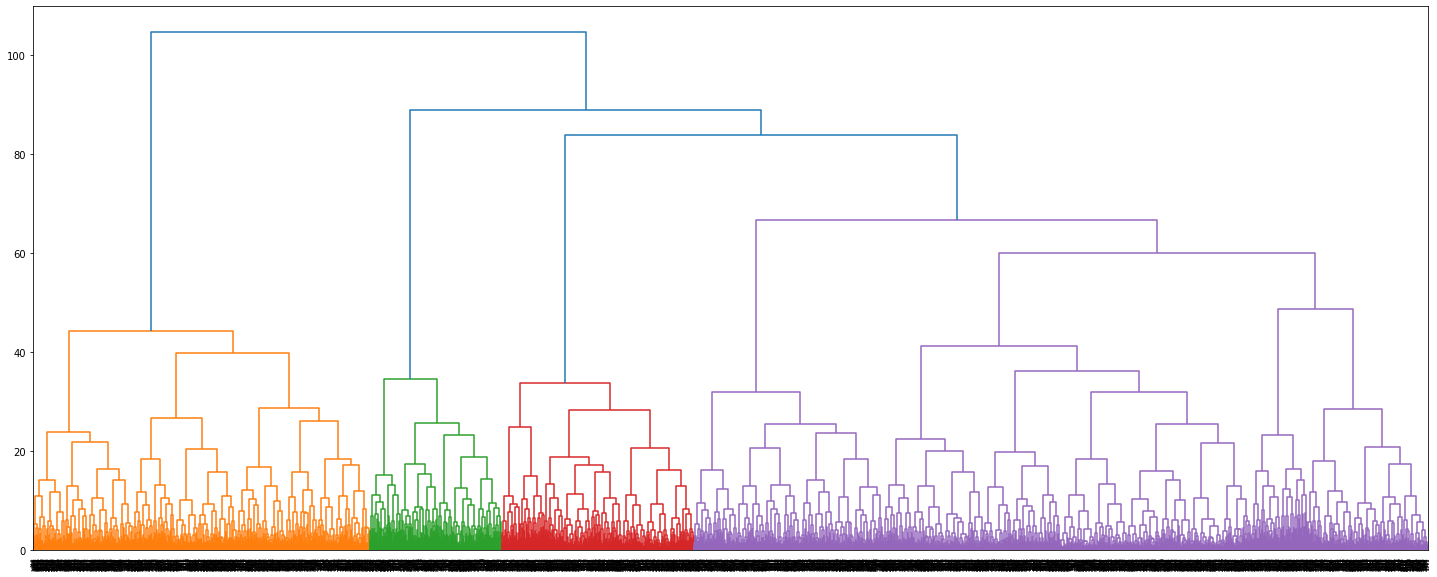

In [41]:
# Построим дендрограмму
Z = linkage(gym_data_sc, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

**Вывод** На основании полученной дендрограммы можно сделать вывод, что можно выделить 4 кластера посетителй фитнес-клуба

### Модель кластеризации

In [42]:
km = KMeans(n_clusters=4, random_state=0) # задаём число кластеров, равное 4, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(gym_data_sc)

In [43]:
gym_data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = gym_data.groupby(['cluster_km']).mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,0.49,0.76,0.38,0.19,1.00,1.90,0.29,28.05,129.70,1.81,2.24,1.20,0.95,0.56
2,0.54,0.86,0.34,0.21,1.00,2.40,0.45,29.99,157.36,2.24,4.70,2.72,2.71,0.09
3,0.50,0.94,0.78,0.57,1.00,10.70,0.54,29.91,161.36,9.77,4.73,1.98,1.98,0.03


**Выводы** По средним показателям признаков по кластерам можно сделать некоторые выводы:
- Кластер 0 характеризуется тем, что туда попали все посетители, которые не указали свой телефон, а также имеют признаки близкие к общим средним показателям.
- Кластер 1 характерен тем, что в нем сгруппированы посетители с наименьшим средними показателями признаков 
- Кластер 2 выделяется тем, что показатель средней посещаемости выше, чем в остальных кластерах, при этом они ходят в фитнес-клуб долше 4 месяцев
- Кластер 3 собрал в себя преимущественно клиентов с годовыми абонементами, которые ходят в фитнес клуб дольше 4 месяцев

###  Визуализация распределения признаков по кластерам

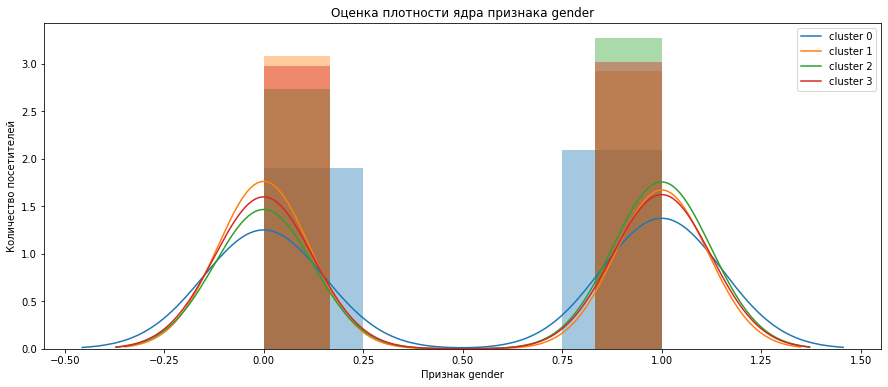

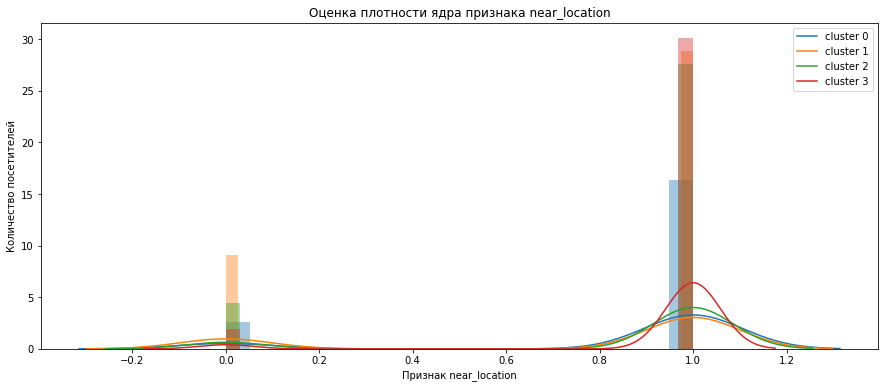

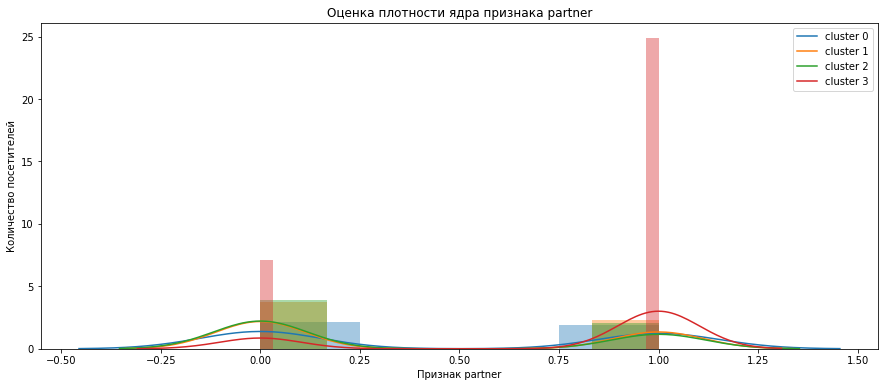

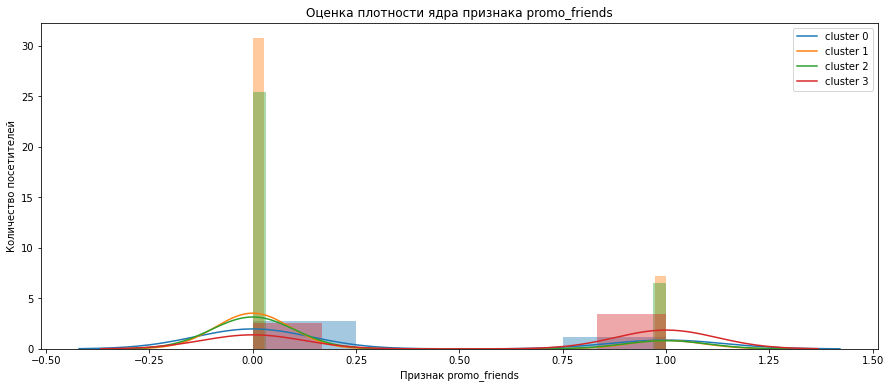

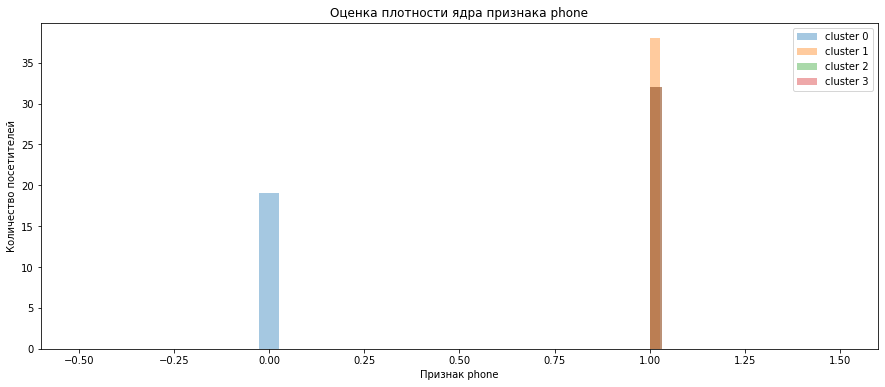

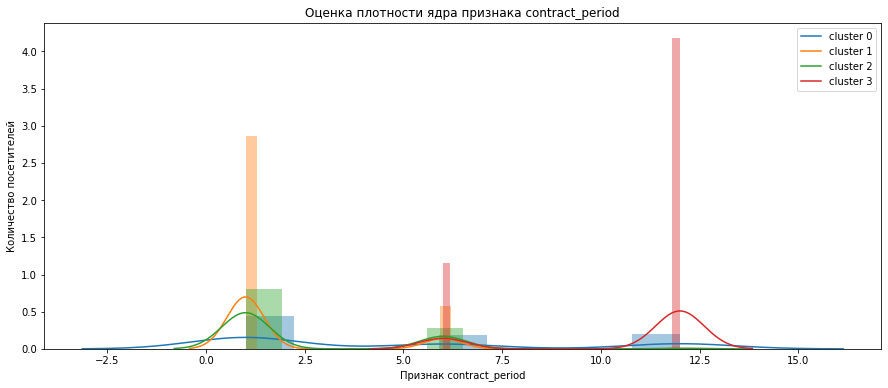

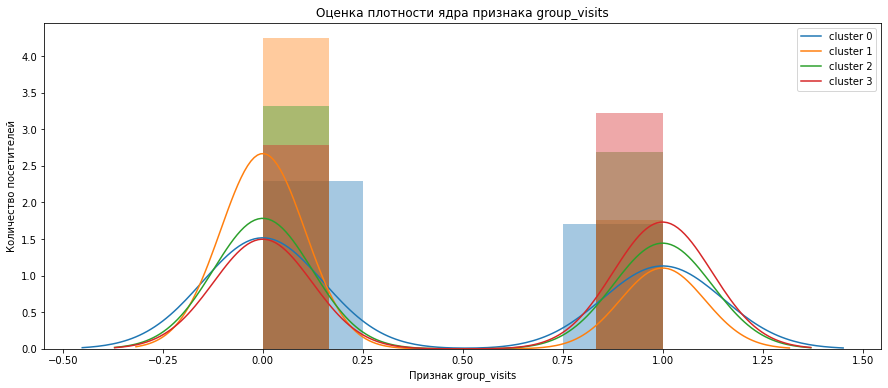

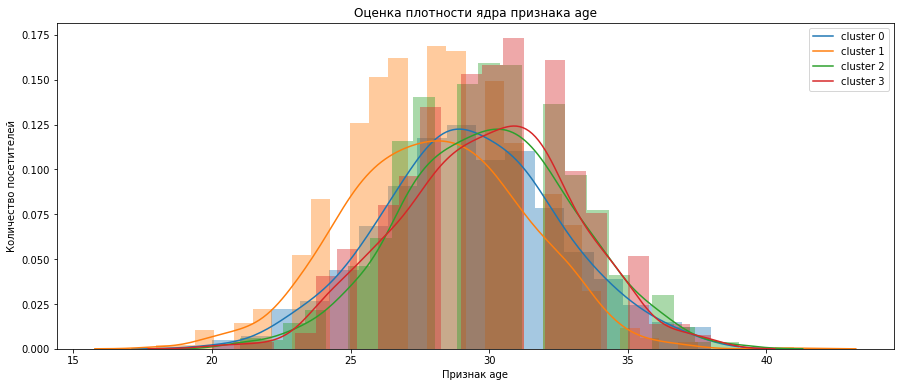

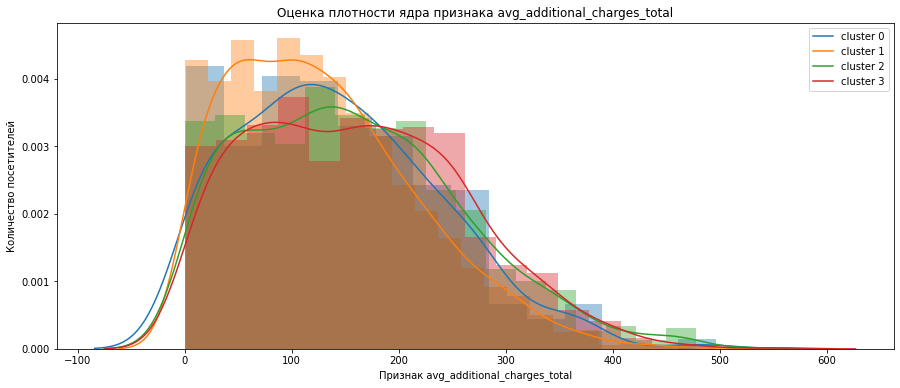

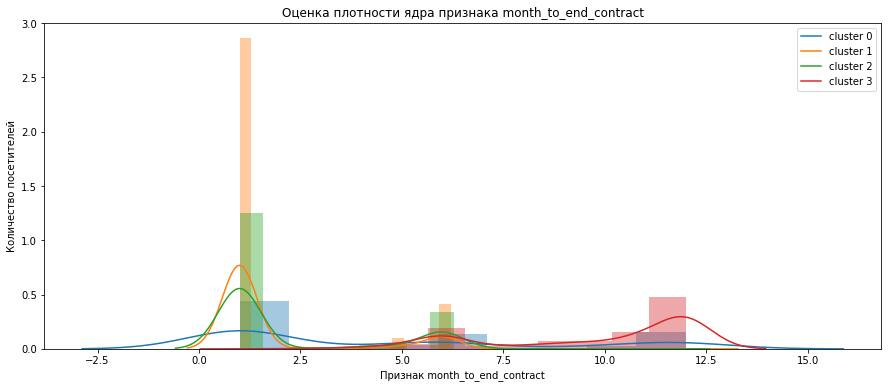

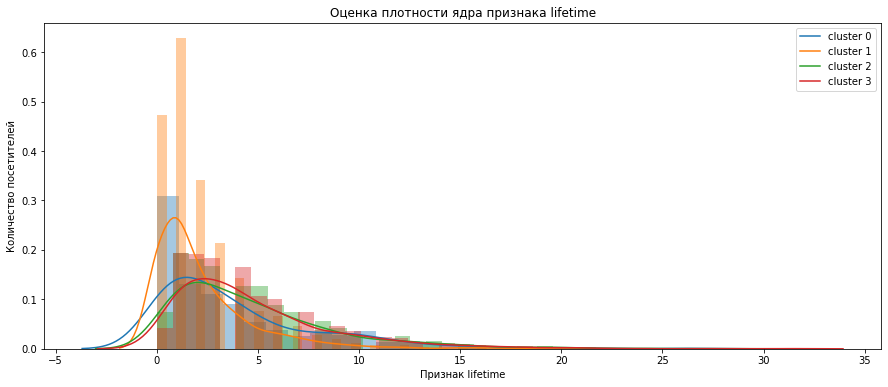

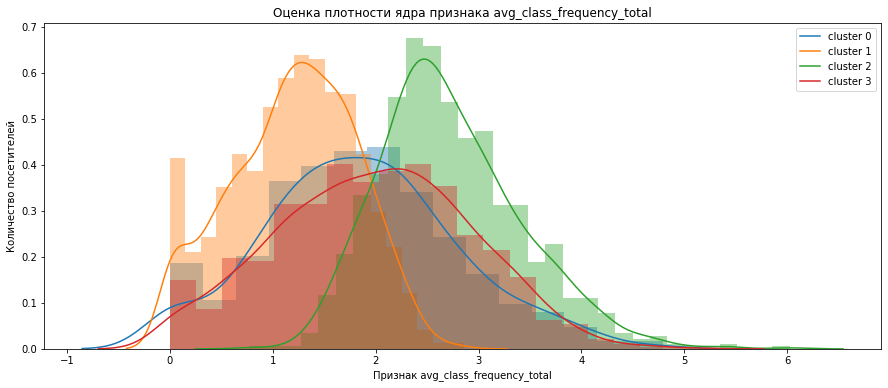

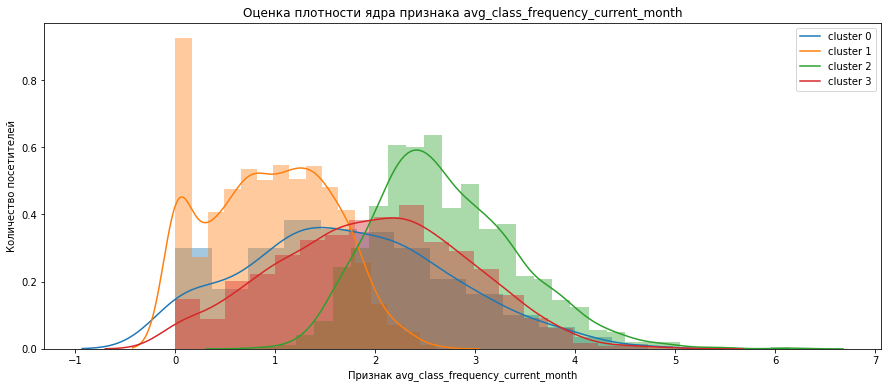

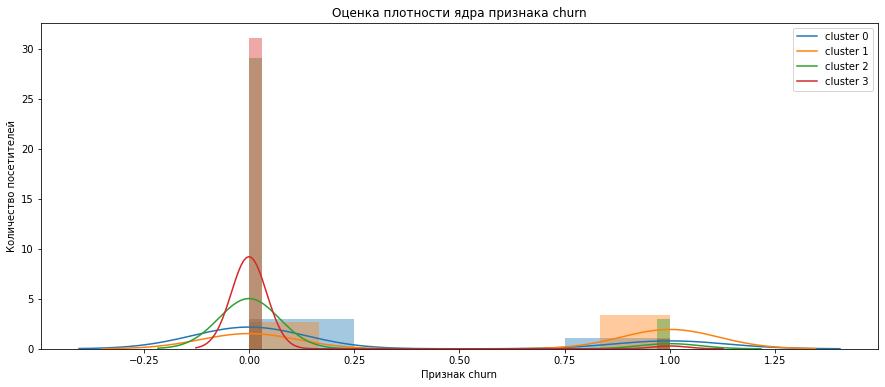

In [44]:
# Построим распределения признаков для кластеров

for column in gym_data.drop('cluster_km', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(15,6))
    sns.distplot(gym_data.query('cluster_km == 0')[column])
    sns.distplot(gym_data.query('cluster_km == 1')[column])
    sns.distplot(gym_data.query('cluster_km == 2')[column])
    sns.distplot(gym_data.query('cluster_km == 3')[column])
    plt.title(f"Оценка плотности ядра признака {column}")
    plt.xlabel(f'Признак {column}') 
    plt.ylabel('Количество посетителей') 
    ax.legend(['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
    plt.show

**Выводы** По распределению признаков дополнительно можно отметить:
- в кластере 3 отсутствуют клиенты, которые приобрели абонемент на 1 месяц
- частота посещений клиентов из кластера 1 стремится к нулю в показателе посещаемости за последний месяц, при этом за весь период превалирует показатель одноразового посещения
- в кластере 2 собраны наиболее активно посещающие фитнес центр посетители
- оценка показателя лайфтайм на мой взгляд немного нивелируется недолгим периодом наблюдений и он бы был более показательным, если бы горизонт наблюдения был глубже.

### Процент оттока по кластерам

In [45]:
gym_data.groupby(['cluster_km'])['churn'].mean()

cluster_km
0   0.27
1   0.56
2   0.09
3   0.03
Name: churn, dtype: float64

**Выводы** Кластер 3 собрал в себя посетителей с наименьшим процентом оттока, что говорит о том, что увеличение показателей признаков до значений характерных для кластера 3 должно привести к снижению общего оттока фитнес-центра.
Кластер 2 также имеет неплохие показатели оттока.
Кластер 1 напротив показывает наиболее высокий процент оттока

## Общие выводы и рекомендации

**Выводы**
По итогу проведенного анализа можно сделать выводы, что меньше подвержены оттоку:
- Посетители покупающие годовые абонементы - вероятно, это показывает серьезность намерения посетителя заниматься спортом дилтельное время;
- Посетители приобретающие абонементы на один месяц с высокой долей вероятности уйдут.
- Посетители работники коропративных клиентов;
- Посетители пришедшие по акции 'Приведи друга';
- Посетители которые в среднем посещяют фитнес-центр 3 и более раз.

**Рекомендации** :
- Необходимо стимулировать посетителей приобретать годовые абонементы, возможно через введение скидок на приобретение годового абонемента по окончании предыдущего абонемента;
- Развитие сотрудничества с корпоративными клиентами стоит продолжать, потому что от них приходят достаточно долгие клиенты;
- Акцию 'Приведи друга' стоит поддерживать.
- Вероятно, принесут хорошие показатели по снижению оттока мероприятия по стимулированию посетителей посещать фитнес клуб 3 и более раз, допустим дополнительный бонус или скидки на дополнительные услуги предоставляемые фитнес центром.
